In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report,
    confusion_matrix, roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

sns.set(style="whitegrid")


In [36]:
#LOAD DATA
df = pd.read_csv("data.csv")

print("Dataset shape:", df.shape)
display(df.head())
df.info()



Dataset shape: (269131, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269131 entries, 0 to 269130
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       269131 non-null  float64
 1   HighBP                269131 non-null  float64
 2   HighChol              269131 non-null  float64
 3   CholCheck             269131 non-null  float64
 4   BMI                   269131 non-null  float64
 5   Smoker                269131 non-null  float64
 6   Stroke                269131 non-null  float64
 7   HeartDiseaseorAttack  269131 non-null  float64
 8   PhysActivity          269131 non-null  float64
 9   Fruits                269131 non-null  float64
 10  Veggies               269131 non-null  float64
 11  HvyAlcoholConsump     269131 non-null  float64
 12  AnyHealthcare         269131 non-null  float64
 13  NoDocbcCost           269131 non-null  float64
 14  GenHlth               269131 non-null  float64
 15  

Number of features: 21
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Target Distribution:


,Count,Percentage (%)
Diabetes_binary,,
0.0,194377,72.22
1.0,39657,14.74
2.0,35097,13.04


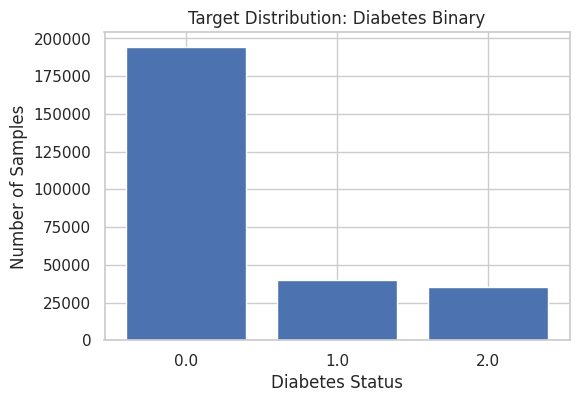

In [37]:
# Target variable
target_col = 'Diabetes_binary'

feature_names = df.drop(columns=[target_col]).columns.tolist()
print("Number of features:", len(feature_names))
print(feature_names)


# Count and percentage
target_counts = df[target_col].value_counts().sort_index()
target_percent = target_counts / len(df) * 100

# Display table
target_distribution = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_percent.round(2)
})

print("Target Distribution:")
display(target_distribution)

# Plot
plt.figure(figsize=(6,4))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.xlabel('Diabetes Status')
plt.ylabel('Number of Samples')
plt.title('Target Distribution: Diabetes Binary')
plt.show()

In [38]:
#Data Splitting and Feature Scaling
X = df.drop(columns=["Diabetes_binary", "Diabetes_binary"])
y = df["Diabetes_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (215304, 21)
Test shape: (53827, 21)


In [39]:
# Binary conversion: 0 = no diabetes, 1 = diabetes
y_train_binary = (y_train > 0).astype(int)
y_test_binary  = (y_test > 0).astype(int)

print("Train labels:", np.unique(y_train_binary))
print("Test labels :", np.unique(y_test_binary))


Train labels: [0 1]
Test labels : [0 1]


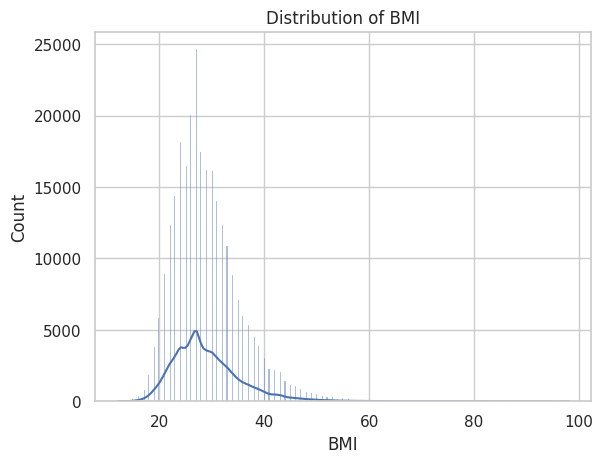

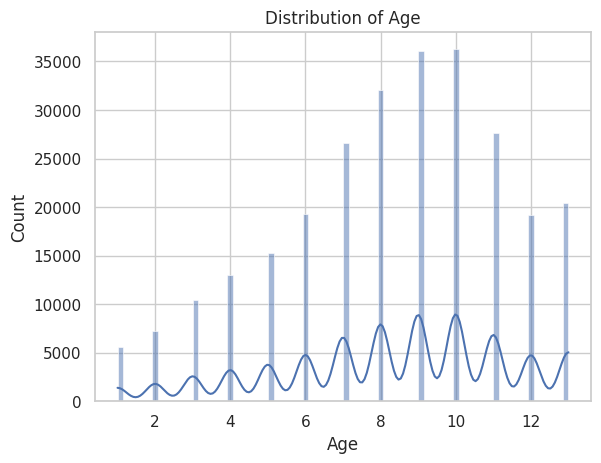

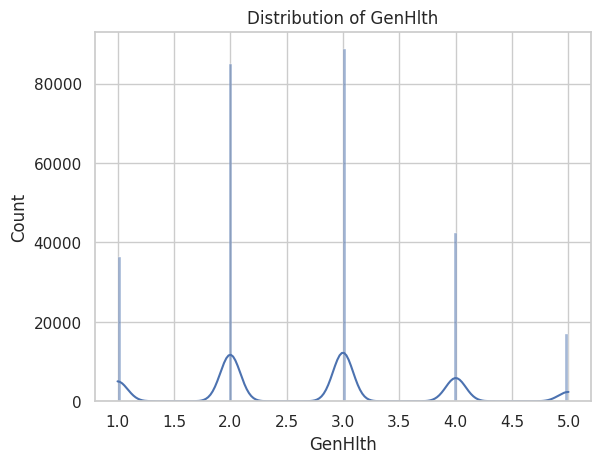

In [40]:
#Feature Distribution Analysis
features_to_plot = ["BMI", "Age", "GenHlth"]

for feature in features_to_plot:
    plt.figure()
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()




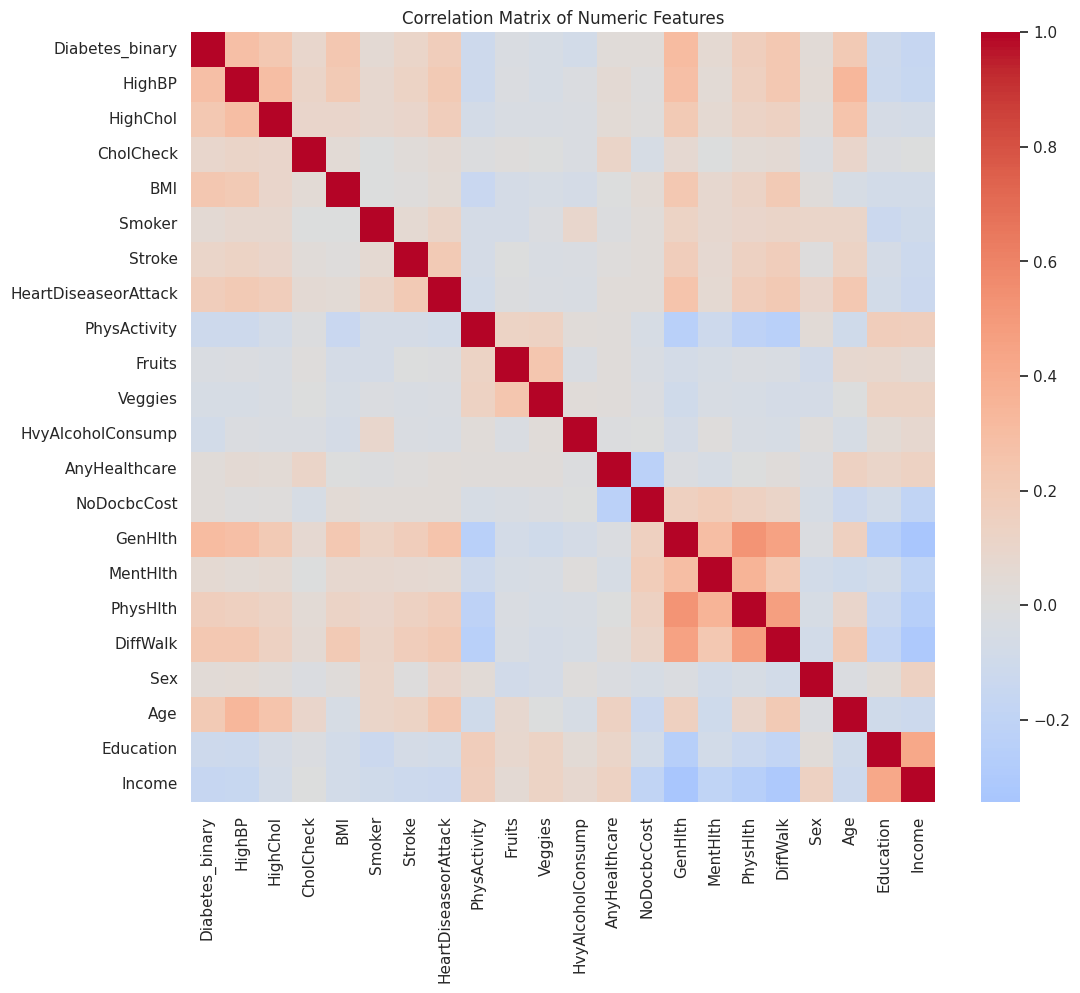

In [41]:
#Numeric Features
numeric_features = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_features].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [42]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced"
)

lr.fit(X_train, y_train_binary)

lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:, 1]


In [43]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_binary)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]


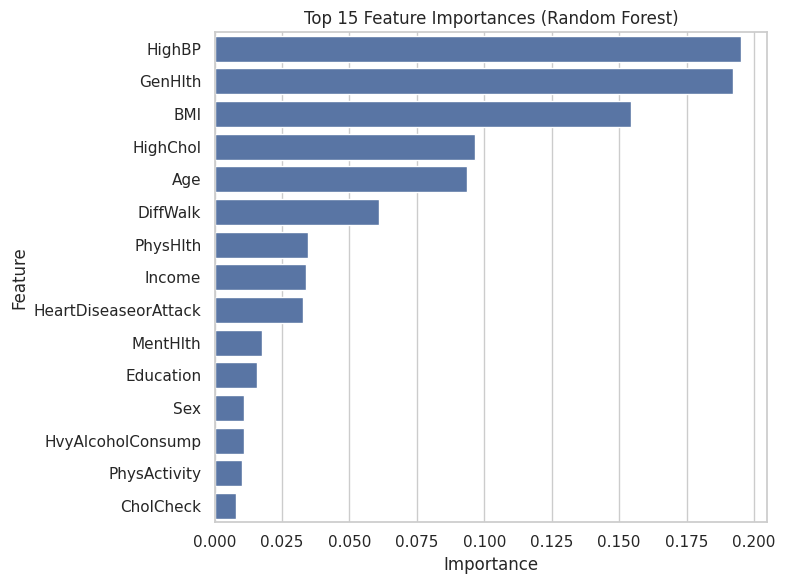

In [44]:
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [45]:
#MLP
mlp = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(128, activation="relu",
          kernel_regularizer=regularizers.l2(1e-3)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation="relu",
          kernel_regularizer=regularizers.l2(1e-3)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu",
          kernel_regularizer=regularizers.l2(1e-3)),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])


In [46]:
mlp.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)


In [47]:
early_stop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)


In [48]:
history = mlp.fit(
    X_train,
    y_train_binary,
    validation_split=0.2,
    epochs=60,
    batch_size=512,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6883 - auc: 0.6628 - loss: 0.7774 - recall: 0.3676 - val_accuracy: 0.7566 - val_auc: 0.7944 - val_loss: 0.6268 - val_recall: 0.4735 - learning_rate: 3.0000e-04
Epoch 2/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7372 - auc: 0.7592 - loss: 0.6525 - recall: 0.3751 - val_accuracy: 0.7624 - val_auc: 0.8016 - val_loss: 0.6004 - val_recall: 0.4704 - learning_rate: 3.0000e-04
Epoch 3/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7477 - auc: 0.7765 - loss: 0.6163 - recall: 0.3818 - val_accuracy: 0.7654 - val_auc: 0.8054 - val_loss: 0.5792 - val_recall: 0.4898 - learning_rate: 3.0000e-04
Epoch 4/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7558 - auc: 0.7856 - loss: 0.5890 - recall: 0.3977 - val_accuracy: 0.7663 - val_auc: 0.8071 - val_loss: 0.5599 - val_recall: 0.4732 - learning_rate: 3.0000e-04
Epoch 5/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7595 - auc: 0.7920 - loss: 0

1683/1683 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


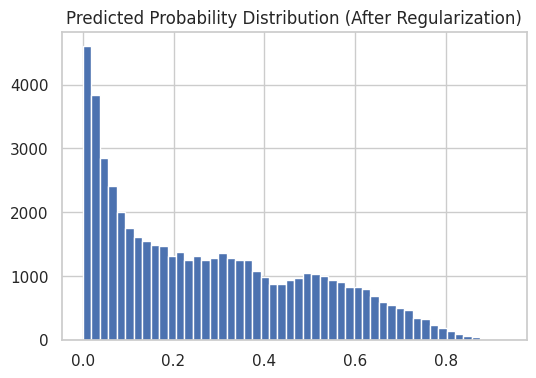

In [49]:
mlp_prob = mlp.predict(X_test).ravel()

plt.figure(figsize=(6,4))
plt.hist(mlp_prob, bins=50)
plt.title("Predicted Probability Distribution (After Regularization)")
plt.show()


In [50]:
train_acc = mlp.evaluate(X_train, y_train, verbose=0)[1]
test_acc = mlp.evaluate(X_test, y_test, verbose=0)[1]

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")


Train Accuracy: 0.7152
Test Accuracy : 0.7171


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


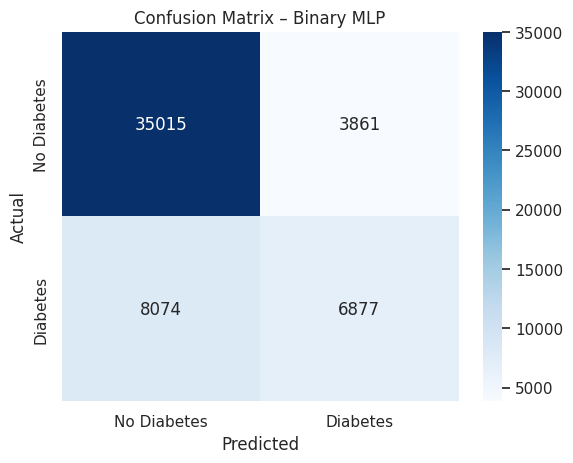

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Binary prediction
y_pred = (mlp.predict(X_test) >= 0.5).astype(int).ravel()

# Confusion matrix (binary)
cm = confusion_matrix(y_test_binary, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Diabetes", "Diabetes"],
    yticklabels=["No Diabetes", "Diabetes"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Binary MLP")
plt.show()

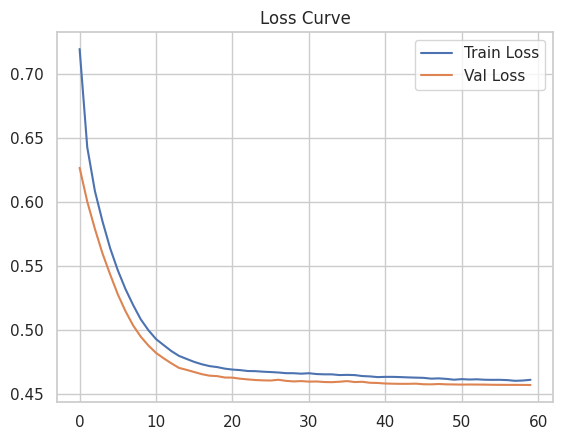

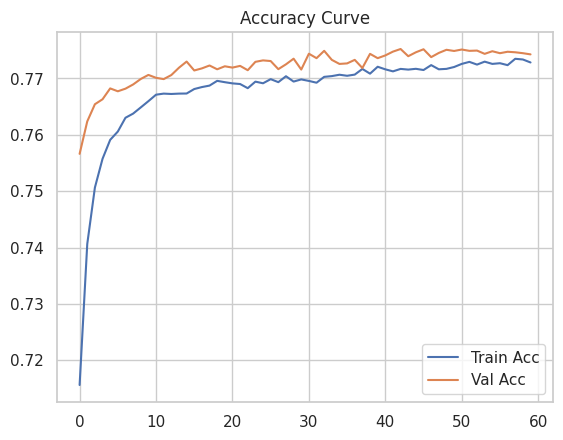

In [52]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [53]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_binary
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight_dict)
history = mlp.fit(
    X_train,
    y_train_binary,
    validation_split=0.2,
    epochs=60,
    batch_size=512,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)


Class weights: {0: np.float64(0.6922913679011711), 1: np.float64(1.8001103623564034)}
Epoch 1/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7689 - auc: 0.8099 - loss: 0.5843 - recall: 0.5282 - val_accuracy: 0.7545 - val_auc: 0.8150 - val_loss: 0.4834 - val_recall: 0.6742 - learning_rate: 1.0000e-05
Epoch 2/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7479 - auc: 0.8091 - loss: 0.5437 - recall: 0.6801 - val_accuracy: 0.7415 - val_auc: 0.8150 - val_loss: 0.5019 - val_recall: 0.7290 - learning_rate: 1.0000e-05
Epoch 3/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7377 - auc: 0.8107 - loss: 0.5315 - recall: 0.7232 - val_accuracy: 0.7358 - val_auc: 0.8150 - val_loss: 0.5111 - val_recall: 0.7473 - learning_rate: 1.0000e-05
Epoch 4/60
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7322 - auc: 0.8094 - loss: 0.5330 - recall: 0.7396 - val_accuracy: 0.7318 - val_auc: 0.8150 - val_loss: 0.5157 - val_recall: 0.7587 - learning_rate: 1.0000e-05
Epoch 5/6

In [54]:
mlp_prob = mlp.predict(X_test).ravel()
mlp_pred = (mlp_prob >= 0.5).astype(int)


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [55]:
print(classification_report(
    y_test_binary,
    mlp_pred,
    target_names=["No Diabetes", "Diabetes"]
))


              precision    recall  f1-score   support

 No Diabetes       0.90      0.68      0.78     38876
    Diabetes       0.49      0.79      0.61     14951

    accuracy                           0.71     53827
   macro avg       0.69      0.74      0.69     53827
weighted avg       0.78      0.71      0.73     53827



In [56]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
import pandas as pd

models = {
    "Logistic Regression": lr_pred,
    "Random Forest": rf_pred,
    "MLP": mlp_pred
}

results = {}

print("--- Classification Report ---")

for name, preds in models.items():
    print(f"\n--- {name} ---")
    print(classification_report(
        y_test_binary,
        preds,
        target_names=["No Diabetes", "Diabetes"],
        zero_division=0
    ))

    results[name] = {
        "Accuracy": accuracy_score(y_test_binary, preds),
        "F1-score": f1_score(y_test_binary, preds),
        "Recall": recall_score(y_test_binary, preds)
    }

results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison Summary Table")
print(results_df.round(2))


--- Classification Report ---

--- Logistic Regression ---
              precision    recall  f1-score   support

 No Diabetes       0.88      0.71      0.79     38876
    Diabetes       0.50      0.75      0.60     14951

    accuracy                           0.72     53827
   macro avg       0.69      0.73      0.69     53827
weighted avg       0.78      0.72      0.74     53827


--- Random Forest ---
              precision    recall  f1-score   support

 No Diabetes       0.80      0.92      0.86     38876
    Diabetes       0.67      0.41      0.51     14951

    accuracy                           0.78     53827
   macro avg       0.74      0.67      0.68     53827
weighted avg       0.77      0.78      0.76     53827


--- MLP ---
              precision    recall  f1-score   support

 No Diabetes       0.90      0.68      0.78     38876
    Diabetes       0.49      0.79      0.61     14951

    accuracy                           0.71     53827
   macro avg       0.69      0.74

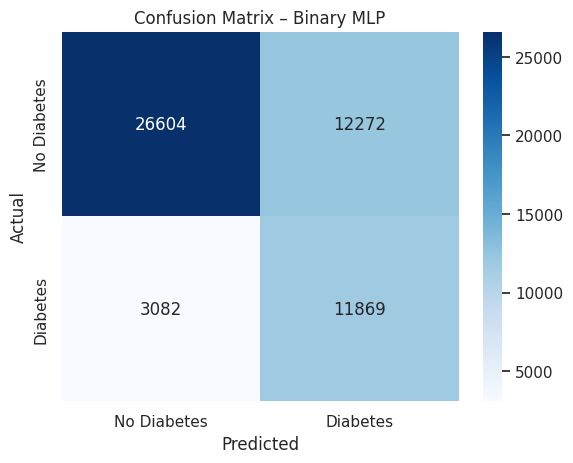

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_binary, mlp_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Diabetes", "Diabetes"],
    yticklabels=["No Diabetes", "Diabetes"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Binary MLP")
plt.show()


In [58]:
y_test_binary = (y_test >= 1).astype(int)

print("Unique y_test_binary:", np.unique(y_test_binary))


Unique y_test_binary: [0 1]


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


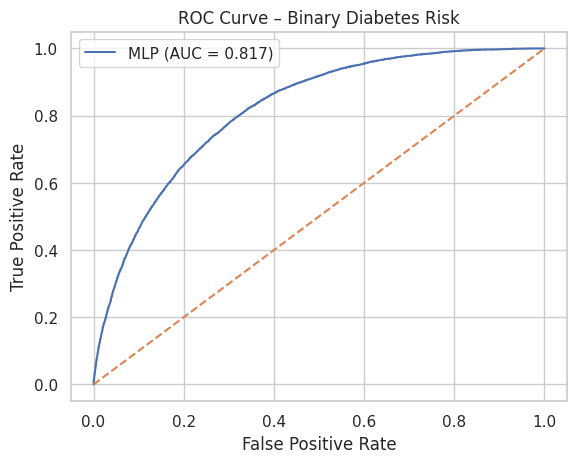

In [59]:
from sklearn.metrics import roc_curve, auc

mlp_prob = mlp.predict(X_test).ravel()

fpr, tpr, _ = roc_curve(y_test_binary, mlp_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"MLP (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Binary Diabetes Risk")
plt.legend()
plt.show()


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


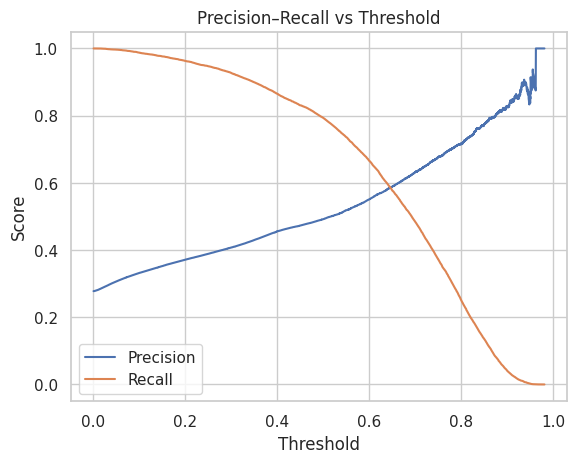

In [60]:
from sklearn.metrics import precision_recall_curve

mlp_prob = mlp.predict(X_test).ravel()

precision, recall, thresholds = precision_recall_curve(
    y_test_binary,
    mlp_prob
)
plt.figure()
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall vs Threshold")
plt.show()


In [61]:
from sklearn.metrics import f1_score

thresholds_to_test = np.linspace(0.1, 0.9, 50)
f1_scores = []

for t in thresholds_to_test:
    preds = (mlp_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test_binary, preds))

best_threshold = thresholds_to_test[np.argmax(f1_scores)]

print("Best threshold:", best_threshold)
print("Best F1-score:", max(f1_scores))


Best threshold: 0.5081632653061224
Best F1-score: 0.6080070391553014


In [62]:
mlp_pred = (mlp_prob >= best_threshold).astype(int)

In [63]:
print("mlp exists:", "mlp" in globals())
print("scaler exists:", "scaler" in globals())
print("feature_names exists:", "feature_names" in globals())
print("best_threshold exists:", "best_threshold" in globals())


mlp exists: True
scaler exists: True
feature_names exists: True
best_threshold exists: True


In [64]:
def inference_from_dataframe(df_new, model, scaler, feature_names, threshold=0.5):
    df_new = df_new.reindex(columns=feature_names, fill_value=0)
    df_scaled = scaler.transform(df_new)
    prob = model.predict(df_scaled).ravel()
    pred = (prob >= threshold).astype(int)
    result = df_new.copy()
    result["Diabetes_Probability"] = prob
    result["Diabetes_Prediction"] = pred

    return result




In [65]:
new_patients = pd.read_csv("new-data.csv")

results = inference_from_dataframe(
    df_new=new_patients,
    model=mlp,
    scaler=scaler,
    feature_names=feature_names,
    threshold=best_threshold
)

display(results)


7928/7928 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_Probability,Diabetes_Prediction
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0.904464,1
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.156388,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0.832423,1
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.441852,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0.440573,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0,0.683636,1
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0,0.633362,1
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,0.037195,0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0,0.421045,0


In [68]:
mlp.save("mlp_diabetes_model.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']

In [69]:
from tensorflow.keras.models import load_model
import joblib

# Load model
mlp_loaded = load_model("mlp_diabetes_model.h5")

# Load scaler & feature names
scaler_loaded = joblib.load("scaler.pkl")
feature_names_loaded = joblib.load("feature_names.pkl")
joblib.dump(lr, "logistic_regression_model.pkl")
joblib.dump(rf, "random_forest_model.pkl")


['random_forest_model.pkl']

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
